In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
class DarkImageRoadDetection:
    def __init__(self):
        """
        Initialize a road detection system optimized for dark images.
        Combines multiple techniques to improve accuracy in low-light conditions.
        """
        # Load a pre-trained segmentation model
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        
        # Define preprocessing
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])

    def preprocess_dark_image(self, image):
        """
        Enhance a dark image to improve feature visibility.
        
        Args:
            image: PIL Image or numpy array
            
        Returns:
            Enhanced image as numpy array
        """
        # Convert PIL Image to numpy if needed
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        else:
            image_np = image.copy()
            
        # Convert to LAB color space
        lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        
        # Split channels
        l, a, b = cv2.split(lab)
        
        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        
        # Merge channels
        enhanced_lab = cv2.merge((cl, a, b))
        
        # Convert back to RGB
        enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        
        return enhanced_rgb

    def detect_road(self, image_path, brightness_threshold=100, method="combined"):
        """
        Detect road in dark images using a combination of techniques.
        
        Args:
            image_path: Path to the input image
            brightness_threshold: Threshold for brightness adjustment
            method: Detection method ("model", "edge", "combined")
            
        Returns:
            Original image and road mask
        """
        # Load image
        original_image = Image.open(image_path).convert('RGB')
        image_np = np.array(original_image)
        
        # Enhance the dark image
        enhanced_image = self.preprocess_dark_image(image_np)
        
        # Create a PIL Image from the enhanced image for model input
        enhanced_pil = Image.fromarray(enhanced_image)
        
        road_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=bool)
        
        if method in ["model", "combined"]:
            # Use semantic segmentation model on enhanced image
            input_tensor = self.transform(enhanced_pil).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                output = self.model(input_tensor)['out']
            
            # Get predicted classes
            output_predictions = output.argmax(1).squeeze(0).cpu().numpy()
            
            # Try multiple potential road classes
            for road_index in [1, 7, 8, 11, 13]:  # Different potential road indices
                road_mask = road_mask | (output_predictions == road_index)
        
        if method in ["edge", "combined"]:
            # Edge-based road detection
            # Convert to grayscale
            gray = cv2.cvtColor(enhanced_image, cv2.COLOR_RGB2GRAY)
            
            # Apply Gaussian blur
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            
            # Apply Canny edge detection
            edges = cv2.Canny(blurred, 50, 150)
            
            # Apply Hough transform to detect lines
            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, 
                                    minLineLength=50, maxLineGap=10)
            
            # Create a mask for the detected lines
            line_mask = np.zeros_like(gray, dtype=np.uint8)
            
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    cv2.line(line_mask, (x1, y1), (x2, y2), 1, 5)
            
            # Combine with road mask
            if method == "combined":
                road_mask = road_mask | line_mask
            else:
                road_mask = line_mask
        
        # Apply thresholding based on brightness to exclude sky
        # Sky is typically brighter than road
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        sky_mask = gray > brightness_threshold
        road_mask = road_mask & ~sky_mask
        
        # Remove small objects and fill holes
        road_mask = self._clean_mask(road_mask)
        
        return image_np, road_mask
    
    def _clean_mask(self, mask, min_size=1000):
        """Clean up the mask to make it more coherent."""
        # Remove small objects
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            mask.astype(np.uint8), connectivity=8)
        
        clean_mask = np.zeros_like(mask)
        for i in range(1, num_labels):  # Skip background (label 0)
            if stats[i, cv2.CC_STAT_AREA] >= min_size:
                clean_mask = clean_mask | (labels == i)
        
        # Apply morphological operations to clean up
        kernel = np.ones((5, 5), np.uint8)
        clean_mask = cv2.morphologyEx(clean_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)
        
        return clean_mask.astype(bool)
    
    def visualize_results(self, image, road_mask, enhanced_image=None):
        """Display the results."""
        if enhanced_image is None:
            enhanced_image = self.preprocess_dark_image(image)
            
        num_plots = 4 if enhanced_image is not None else 3
        fig, axes = plt.subplots(1, num_plots, figsize=(20, 5))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title("Original Dark Image")
        axes[0].axis("off")
        
        # Enhanced image
        if enhanced_image is not None:
            axes[1].imshow(enhanced_image)
            axes[1].set_title("Enhanced Image")
            axes[1].axis("off")
            
            # Road mask
            axes[2].imshow(road_mask, cmap='gray')
            axes[2].set_title("Road Mask")
            axes[2].axis("off")
            
            # Road only
            road_only = image.copy()
            mask_3d = np.stack([road_mask] * 3, axis=2)
            road_only[~mask_3d] = 0
            
            axes[3].imshow(road_only)
            axes[3].set_title("Road Only")
            axes[3].axis("off")
        else:
            # Road mask
            axes[1].imshow(road_mask, cmap='gray')
            axes[1].set_title("Road Mask")
            axes[1].axis("off")
            
            # Road only
            road_only = image.copy()
            mask_3d = np.stack([road_mask] * 3, axis=2)
            road_only[~mask_3d] = 0
            
            axes[2].imshow(road_only)
            axes[2].set_title("Road Only")
            axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()
        
        return road_only

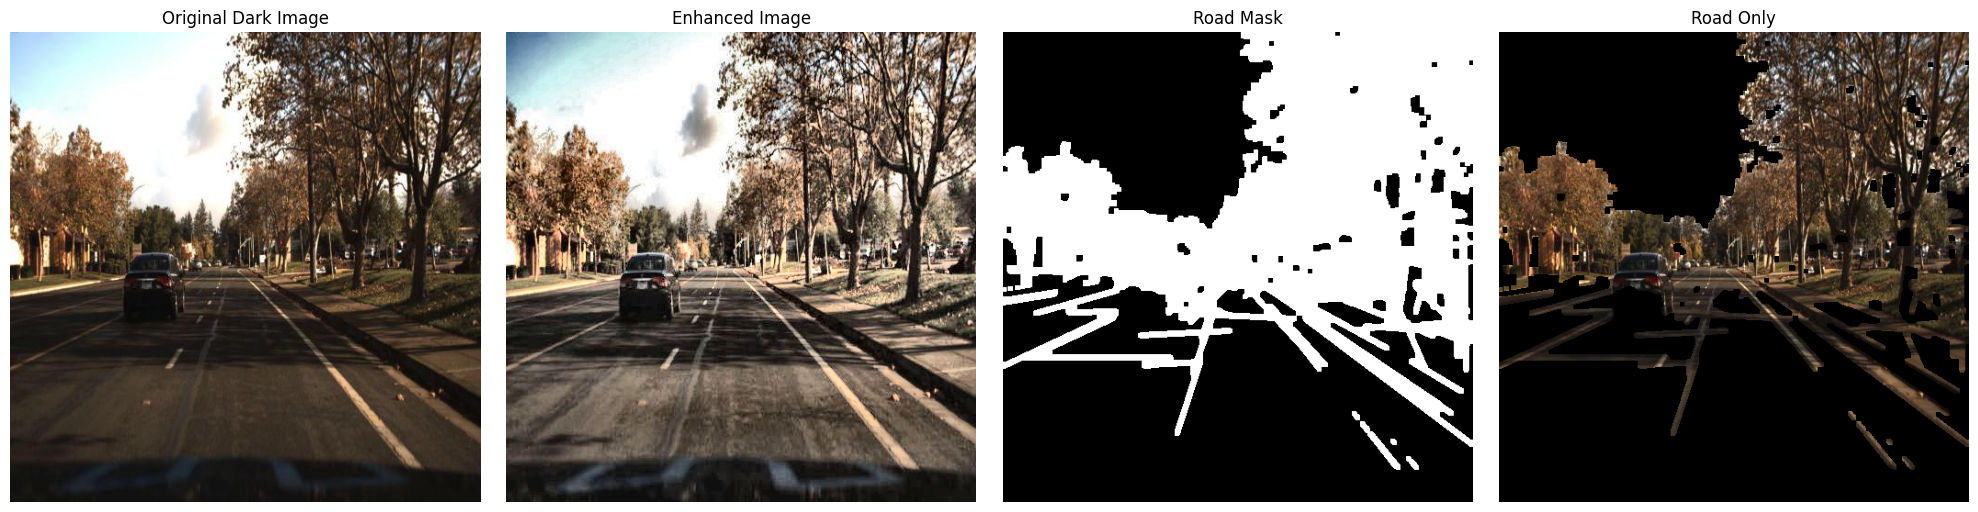

Road area: 43.46% of the image

Trying different brightness thresholds to fine-tune:
Threshold 80: 35.35% road area
Threshold 100: 41.37% road area
Threshold 120: 43.46% road area
Threshold 140: 44.79% road area
Threshold 160: 45.76% road area


In [8]:
# Example usage
if __name__ == "__main__":
    # Initialize the road detection system
    road_detector = DarkImageRoadDetection()
    
    # Path to input image
    image_path = r"D:\minie\code\data\export\1478019961182003465_jpg.rf.6f9292b69d3508b6ab346a907dfae163.jpg"
    
    # Enhance the image and detect road
    original_image = Image.open(image_path).convert('RGB')
    enhanced_image = road_detector.preprocess_dark_image(np.array(original_image))
    
    # Detect road with different brightness thresholds to test
    image, road_mask = road_detector.detect_road(
        image_path, 
        brightness_threshold=120,  # Adjust this based on your image
        method="combined"  # Try "model", "edge", or "combined"
    )
    
    # Visualize the results
    road_only = road_detector.visualize_results(image, road_mask, enhanced_image)
    
    # Calculate road area percentage
    road_percentage = (np.sum(road_mask) / road_mask.size) * 100
    print(f"Road area: {road_percentage:.2f}% of the image")
    
    # You can also try different thresholds
    print("\nTrying different brightness thresholds to fine-tune:")
    for threshold in [80, 100, 120, 140, 160]:
        _, test_mask = road_detector.detect_road(
            image_path, 
            brightness_threshold=threshold,
            method="combined"
        )
        percentage = (np.sum(test_mask) / test_mask.size) * 100
        print(f"Threshold {threshold}: {percentage:.2f}% road area")